In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from Ge_calculation import GAP, MD_run
from Ge_analysis import *
import matplotlib.pyplot as plt
import pickle
from ase.io.cfg import read_cfg
import numpy as np
import os
from ase import build
from ase.atoms import Atoms
from quippy.potential import Potential
from quippy.descriptors import Descriptor
from ase.io.proteindatabank import read_proteindatabank, write_proteindatabank
from ase.io.lammpsdata import write_lammps_data
from scipy.optimize import curve_fit
from ase.io import Trajectory
from ase.io import read
from ase.eos import EquationOfState
from ase.visualize import view
from copy import deepcopy
from ase.io.castep import read_castep_castep, read_param
from ase.io import read
from ase.io.extxyz import read_xyz
import pandas as pd
from ase.lattice import hexagonal, tetragonal, orthorhombic
from ase.constraints import StrainFilter, UnitCellFilter, ExpCellFilter, FixAtoms
from ase.optimize import BFGS
import pymatgen.ext.matproj as mp
import pymatgen.core.periodic_table as pt
import pymatgen.io.ase as pase
import cProfile
import re
from sklearn import decomposition

In [4]:
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans serif"]})
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{siunitx}']

def tex_escape(text):
    """
        :param text: a plain text message
        :return: the message escaped to appear correctly in LaTeX
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(str(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)

<ipython-input-4-b8d93ddf7411>:6: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [


In [5]:
GE = '/Users/Moji/Documents/Summer20/Ge/'
os.chdir('/Users/Moji/Documents/Summer20/Ge/')
pot_dir ='/Users/Moji/Documents/Summer20/Ge/Potentials/rescaling/'

In [29]:
resc_amo = GAP(train_file= pot_dir + 'resc_amorphs_train.xyz', val_file=pot_dir + 'resc_amorphs_validate.xyz',
               pot=pot_dir + 'resc_amorphs_as5_ds002_vT.xml')

Training set structure count: 193
Validation set structure count: 48
Reading xyz file (may take a while)
Read configs, now fixing virials
Config labels: ['amorph', 'hiT_amorph', 'liq_rescale_120', 'liq_rescale_80']


['amorph', 'hiT_amorph', 'liq_rescale_120', 'liq_rescale_80']

In [30]:
resc_amo.calc()
resc_amo.analyse()
resc_amo.save('/Users/Moji/Documents/Summer20/Ge/Pickles/resc_amo')

Config amorph done
Config hiT_amorph done
Config liq_rescale_120 done
Config liq_rescale_80 done
Config amorph done
Config hiT_amorph done
Config liq_rescale_120 done
Config liq_rescale_80 done
--- 340.26622700691223 seconds ---


In [ ]:
cProfile.run("GAP(train_file= pot_dir + 'resc_orig_train.xyz', val_file=pot_dir + 'resc_orig_validate.xyz',"+
                                             "pot=pot_dir + 'resc_orig_as5_ds002_vT.xml',"+
                              "sorted_order=[0,3,4,1,2,6,5])")

In [15]:
resc_orig = GAP(train_file= pot_dir + 'resc_orig_train.xyz', val_file=pot_dir + 'resc_orig_validate.xyz',
                               pot=pot_dir + 'resc_orig_as5_ds002_vT.xml',
                sorted_order=[0,3,4,1,2,6,5])
resc_orig.config_labels

Training set structure count: 361
Validation set structure count: 90
Reading xyz file (may take a while)
Read configs, now fixing virials
Config labels: ['amorph', 'liq', 'hiT_liq', 'hiT_amorph', 'inter', 'liq_rescale_120', 'liq_rescale_80']
New order:  ['amorph', 'hiT_amorph', 'inter', 'liq', 'hiT_liq', 'liq_rescale_80', 'liq_rescale_120']


['amorph',
 'hiT_amorph',
 'inter',
 'liq',
 'hiT_liq',
 'liq_rescale_80',
 'liq_rescale_120']

In [7]:
hp64_GAP = GAP(train_file=GE+'Potentials/hp_liquid/hpliq_64/hpliq_64_train.xyz',
               val_file=GE+'Potentials/hp_liquid/hpliq_64/hpliq_64_validate.xyz',
               pot=GE+'Potentials/hp_liquid/hpliq_64/hpliq_64_as5_ds002_vT.xml',
               sorted_order=[0, 3, 4, 1, 2])

Training set structure count: 231
Validation set structure count: 50
Reading xyz file (may take a while)
Read configs, now fixing virials
Config labels: ['amorph', 'liq', 'hiT_liq', 'hiT_amorph', 'inter']
New order:  ['amorph', 'hiT_amorph', 'inter', 'liq', 'hiT_liq']


In [8]:
hp64_GAP.calc()
hp64_GAP.analyse()
hp64_GAP.save(GE+'Pickles/hp64_GAP')

Config amorph done
Config hiT_amorph done
Config inter done
Config liq done
Config hiT_liq done
Config amorph done
Config hiT_amorph done
Config inter done
Config liq done
Config hiT_liq done
--- 283.8830580711365 seconds ---


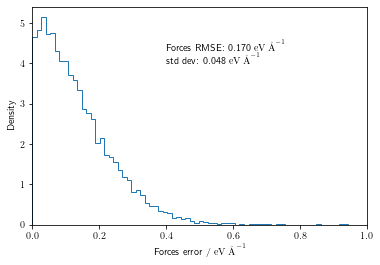

In [29]:
#energy_error(hp64_GAP)
GAP = hp64_GAP
fig, axs = plt.subplots()

axs.hist(abs(np.array(flatten((GAP.data_dict['F_err_v'])))),
         label='test set', density=True, bins=100, histtype='step')
axs.set(xlabel=r'Forces error / \si{eV.\angstrom^{-1}}', ylabel='Density',
        xlim=(0,1.0))
axs.text(0.4, 4, 'Forces RMSE: {0:1.3f} {2}\n      std dev: {1:1.3f} {2}'.format(
            np.average([i['rmse'] for i in GAP.data_dict['F_rmse_v']]),
            np.average([i['std'] for i in GAP.data_dict['F_rmse_v']]),
            r'\si{eV.\angstrom^{-1}}'))
fig.savefig(GE+'Analysis/hp64_F_err_placeholder.png', bbox_inches='tight', dpi=100)


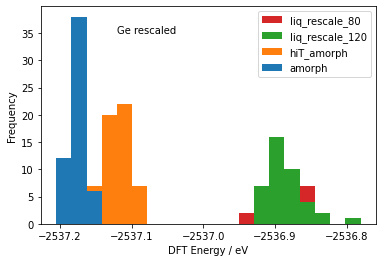

In [173]:
fig, axs = plt.subplots()

axs.hist(resc_amo.data_dict['QM_E_t'], label=resc_amo.config_labels, bins=20,
         histtype='stepfilled')
axs.text(-2537.12, 35, 'Ge rescaled')
axs.set(xlabel='DFT Energy / eV', ylabel='Frequency')
axs.legend()

In [127]:
resc_amo_vs = [[np.trace(i)/3 for i in j] for j in resc_amo.data_dict['QM_V_t']]

In [16]:
resc_orig_vs = [np.array([np.trace(i)/(3*resc_orig.T_configs[ct][ct2].get_volume()) for ct2,i in enumerate(j)])
                for ct,j in enumerate(resc_orig.data_dict['QM_V_t'])]





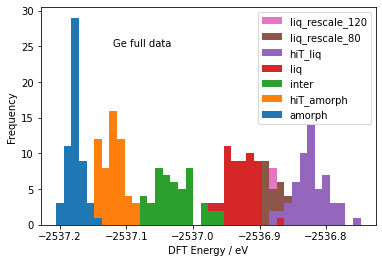

In [79]:
fig, axs = plt.subplots()

axs.hist(resc_orig.data_dict['QM_E_t'], label=resc_orig.config_labels, bins=40,
         histtype='stepfilled')
axs.text(-2537.12, 25, 'Ge full data')
axs.set(xlabel='DFT Energy / eV', ylabel='Frequency')
axs.legend()
fig.savefig(GE+'Analysis/Ge_orig_E.png')

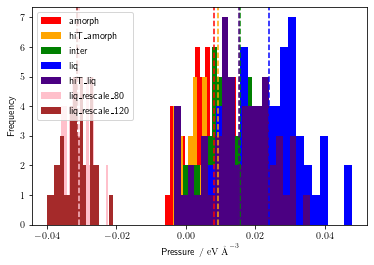

In [24]:
colors=['r','Orange','g','b','Indigo','Pink', 'Brown']
fig, axs = plt.subplots()
for i in range(7):
    axs.hist(resc_orig_vs[i], label=tex_escape(resc_orig.config_labels[i]), bins=20,
             histtype='stepfilled', color=colors[i])
    axs.axvline(resc_orig_vs[i].mean(), linestyle='dashed', color=colors[i])
#axs.text(-40, 9, 'resc_orig MD-trained')
axs.set(xlabel=r'Pressure / \si{eV.\angstrom^{-3}}', ylabel='Frequency')
axs.legend()
#fig.savefig(GE+'Analysis/Ge_pressure.png', bbox_inches='tight', dpi=100)

In [9]:
si_pot = '/Users/Moji/Documents/Summer20/Ge/Potentials/Si_MDGAP_val/'
Si = GAP(train_file=si_pot+'train.xyz', val_file=si_pot+'validate.xyz', pot=si_pot+'Si_as5_ds002_vT.xml',
         sorted_order=[0, 2, 1, 3, 4])

Training set structure count: 201
Validation set structure count: 50
Reading xyz file (may take a while)
Read configs, now fixing virials
Config labels: ['amorph', 'inter', 'hiT_amorph', 'liq', 'hiT_liq']
New order:  ['amorph', 'hiT_amorph', 'inter', 'liq', 'hiT_liq']


In [27]:
Si.calc()
Si.analyse()

Config amorph done
Config hiT_amorph done
Config inter done
Config liq done
Config hiT_liq done
Config amorph done
Config hiT_amorph done
Config inter done
Config liq done
Config hiT_liq done
--- 244.09408283233643 seconds ---


In [ ]:
Si.save('/Users/Moji/Documents/Summer20/Ge/Pickles/Si')

In [10]:
Si.load('/Users/Moji/Documents/Summer20/Ge/Pickles/Si')

Load successful
data_dict:  dict_keys(['QM_E_t', 'QM_F_t', 'QM_V_t', 'GAP_E_t', 'GAP_F_t', 'GAP_V_t', 'E_err_t', 'F_err_t', 'V_err_t', 'E_rmse_t', 'F_rmse_t', 'V_rmse_t', 'QM_E_v', 'QM_F_v', 'QM_V_v', 'GAP_E_v', 'GAP_F_v', 'GAP_V_v', 'E_err_v', 'F_err_v', 'V_err_v', 'E_rmse_v', 'F_rmse_v', 'V_rmse_v'])


In [ ]:
fig, axs = plt.subplots()

axs.hist(resc_orig.data_dict['QM_E_t'], label=resc_orig.config_labels, bins=40,
         histtype='stepfilled')
axs.text(-2537.12, 25, 'Ge full data')
axs.set(xlabel='DFT Energy / eV', ylabel='Frequency')
axs.legend()
fig.savefig(GE+'Analysis/Ge_orig_E.png')

In [ ]:
colors=['r','Orange','g','b','Indigo','Pink', 'Brown']
fig, axs = plt.subplots()
for i in range(7):
    axs.hist(resc_orig_vs[i], label=resc_orig.config_labels[i], bins=20,
             histtype='stepfilled', color=colors[i])
    axs.axvline(resc_orig_vs[i].mean(), linestyle='dashed', color=colors[i])
#axs.text(-40, 9, 'resc_orig MD-trained')
axs.set(xlabel='Pressure / eVA^-3', ylabel='Frequency')
axs.legend()
fig.savefig(GE+'Analysis/Ge_pressure.png')

In [11]:
Si_vs = [[np.trace(i)/(3*Si.T_configs[ct][ct2].get_volume()) for ct2,i in enumerate(j)]
                for ct,j in enumerate(Si.data_dict['QM_V_t'])]
Si_vs = np.array(Si_vs)


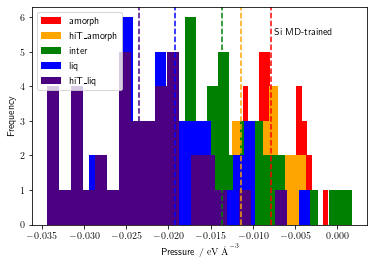

In [25]:
colors=['r','Orange','g','b','Indigo']
fig, axs = plt.subplots()
for i in range(5):
    axs.hist(Si_vs[i], label=tex_escape(Si.config_labels[i]), bins=20,
             histtype='stepfilled', color=colors[i])
    axs.axvline(Si_vs[i].mean(), linestyle='dashed', color=colors[i])
#axs.text(-40, 9, 'Si MD-trained')
axs.set(xlabel=r'Pressure / \si{eV.\angstrom^{-3}}', ylabel='Frequency')
axs.text(-0.0075, 5.5, 'Si MD-trained')
axs.legend()
#fig.savefig('/Users/Moji/Documents/Summer20/Ge/Analysis/Si_pressure.png', bbox_inches='tight')

In [33]:
resc_orig_MD = MD_run('/Users/Moji/Documents/Summer20/Ge/MD_runs/rescaling/resc_orig_as5_ds002_vT/run_64001')

In [37]:
Si_MD = MD_run('/Users/Moji/Documents/Summer20/Ge/MD_runs/Si_liquid_gen/as5_ds002_vT/run_64001/')

In [40]:
Si_MD.configs[-1].set_atomic_numbers(64*[14])

In [106]:
tmp = resc_amo_MD.structure_factors(selection=([i for i in range(30,100)]+[220]),
                              #rings_dir='/Users/Moji/Documents/Summer20/Ge/MD_runs/Si_liquid_gen/rings',
                                    read_only=False)

R.I.N.G.S ran successfully


In [221]:
tmp = Si_MD.structure_factors(selection=([i for i in range(30,100)]+[220]),
                              rings_dir='MD_runs/Si_liquid_gen/rings',
                              read_only=True)

R.I.N.G.S ran successfully


In [224]:
#resc_amo_MD.bin_fit(s_selection=range(0,-1,1), q_selection=[1,12], nbins=200)
Si_MD.bin_fit(s_selection=[-1], q_selection=[1,12], nbins=200)

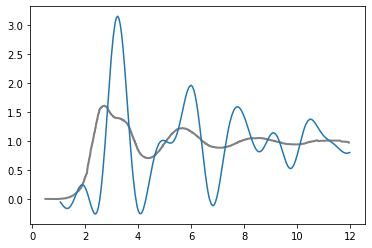

In [225]:
fig, axs = plt.subplots()
axs.errorbar(*Si_MD.Sq_x_av, yerr=None)
axs.plot(Si_exp_Sq[0], Si_exp_Sq[1]-0.5, color='Gray', linewidth=2)

In [47]:
Si_exp_Sq = np.genfromtxt('/Users/Moji/Documents/paper_data/Si_Sq_exp_Waseda1974.txt', delimiter=', ').T
Si_exp_Sq[1] += -0.5

In [134]:
Si_lit_db = GAP('/Users/Moji/Documents/Summer20/Ge/Structure_databases/gp_iter6_sparse9k.xml.xyz',
                parameter_names=['dft_energy', 'dft_force', 'dft_virial'])

Training set structure count: 2442
Reading xyz file (may take a while)
Read configs, now fixing virials
Config labels: ['sh', 'dia', 'bt', 'liq', 'amorph', 'surface_001', 'surface_110', 'surface_111', 'surface_111_pandey', 'crack_110_1-10', 'crack_111_1-10', 'sp', 'sp2', 'interstitial', 'screw_disloc', 'divacancy', 'vacancy', '111adatom', 'surface_111_3x3_das', 'decohesion', 'bc8', 'bcc', 'fcc', 'hcp', 'hex_diamond', 'st12']


In [135]:
Si_lit_db.save('/Users/Moji/Documents/Summer20/Ge/Pickles/Si_lit_db')


In [163]:
Si_lit_vs = [[np.trace(i)/3 for i in j if not i is None] for ct,j in enumerate(Si_lit_db.data_dict['QM_V_t'])
             if Si_lit_db.config_labels[ct] in ['liq']]

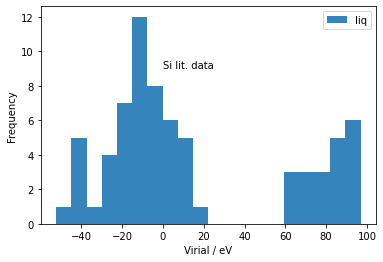

In [191]:
fig, axs = plt.subplots()

axs.hist(Si_lit_vs, label=Si_lit_db.config_labels[3], bins=20,
         histtype='stepfilled', alpha=0.9)
axs.text(0, 9, 'Si lit. data')
axs.set(xlabel='Virial / eV', ylabel='Frequency')
axs.legend(loc='upper right')

In [82]:
Si_hp_MD_1 = MD_run(GE+'MD_runs/Si_hp_liquid/run_1')

In [83]:
for i in Si_hp_MD_1.configs:
    i.set_atomic_numbers([32]*64)

In [77]:
Si_hp_MD_1.timesteps.index(120000)

120

In [5]:
# Si_pot = Potential(param_filename=GE+'Potentials/Si_MDGAP_val/Si_as5_ds002_vT.xml', name='liq_amo')
# Si_hcp = Potential(param_filename=GE+'Potentials/crystals/Si/hcp/Si_as5_ds002_vT_hcp.xml')
# Si_hp_64 = Potential(param_filename=GE+'Potentials/crystals/Si/hp_64/Si_hp_64_as5_ds002_vT.xml')
pot = Potential(param_filename=GE+'Potentials/parameter_explore/as5_ds002_vT.xml')
pot_hp_orig = Potential(param_filename=GE+'Potentials/crystals/hp_orig/hp_orig_as5_ds002_vT.xml')
pot_hp_64 = Potential(param_filename=GE+'Potentials/crystals/hp_64/hp_64_as5_ds002_vT.xml')
pot_hp_64_sup30 = Potential(param_filename=GE+'Potentials/crystals/hp_64_sup30/hp_64_sup30_as5_ds002_vT.xml')
pot_hp_sup30_orig = Potential(param_filename=GE+'Potentials/crystals/hp_sup30_orig/hp_sup30_orig_as5_ds002_vT.xml')
pot_hpliq_64 = Potential(param_filename=GE+'Potentials/hp_liquid/hpliq_64/hpliq_64_as5_ds002_vT.xml')
pot_hpliq_amoliq = Potential(param_filename=GE+'Potentials/hp_liquid/hpliq_amoliq/hpliq_amoliq_as5_ds002_vT.xml')
pot_hpliq_full = Potential(param_filename=GE+'Potentials/hp_liquid/hpliq_full/hpliq_full_as5_ds002_vT.xml')
#pot = Potential(param_filename='/Users/Moji/Documents/Summer20/Ge/Potentials/Si_MDGAP_val/Si_as5_ds002_vT.xml')

In [6]:
Ge_pots = [pot, pot_hp_orig, pot_hp_64, pot_hp_64_sup30, pot_hp_sup30_orig,
           pot_hpliq_64, pot_hpliq_amoliq, pot_hpliq_full]
Ge_pot_labels = ['0P GAP', 'hp_all', 'hp_64', 'hp_64_sup30', 'hp_sup30_orig',
           'hpGAP_64', 'hpGAP_amoliq', 'hpGAP_full']
for i,val in enumerate(Ge_pots):
    val.name = Ge_pot_labels[i]
# Si_pots = [Si_pot, Si_hcp, Si_hp_64]
# Si_pot_labels = ['liq_amo_64', 'Si_hcp', 'Si_hp_64']
# for i,val in enumerate(Si_pots):
#     val.name = Si_pot_labels[i]

In [7]:
os.chdir('/Users/Moji/Documents/Summer20/Ge/Analysis/crysts')

In [8]:
with mp.MPRester() as m:
    results = m.query(criteria={"pretty_formula":'Ge'},
                            properties=["exp.tags", "icsd_ids", "task_id", "density", "final_structure"])
    #results = [m.get_structure_by_material_id(i, conventional_unit_cell=True) for i in ['mp-78', 'mp-1061054']]
results

[{'exp.tags': ['Germanane'],
  'icsd_ids': [192507],
  'task_id': 'mp-1067619',
  'density': 3.0890649653867857,
  'final_structure': Structure Summary
  Lattice
      abc : 4.050405074226528 4.050405074226528 10.993359
   angles : 90.0 90.0 120.00001754645537
   volume : 156.1916750206266
        A : 2.025202 -3.507754 0.0
        B : 2.025202 3.507754 0.0
        C : 0.0 0.0 10.993359
  PeriodicSite: Ge (0.0000, 0.0000, 5.2488) [0.0000, 0.0000, 0.4775]
  PeriodicSite: Ge (0.0000, 0.0000, 10.7455) [0.0000, 0.0000, 0.9775]
  PeriodicSite: Ge (2.0252, -1.1693, 4.5606) [0.6667, 0.3333, 0.4148]
  PeriodicSite: Ge (2.0252, 1.1693, 10.0573) [0.3333, 0.6667, 0.9148]},
 {'exp.tags': ['Germanium', 'Germanium - A4'],
  'icsd_ids': [76267,
   636535,
   76146,
   636527,
   44610,
   53788,
   53642,
   181071,
   184252,
   41980,
   44841,
   636528,
   43422,
   54237,
   426941],
  'task_id': 'mp-32',
  'density': 5.041970034757574,
  'final_structure': Structure Summary
  Lattice
      abc 

In [10]:
results[10]

{'exp.tags': ['Germanium',
  'Germanium - HP',
  'Germanium - HP(Cmca)',
  'High pressure experimental phase'],
 'icsd_ids': [94305, 248479, 189804, 94306, 189803, 248478],
 'task_id': 'mp-1079020',
 'density': 6.152106319155599,
 'final_structure': Structure Summary
 Lattice
     abc : 5.35711117128663 5.35711117128663 5.882045
  angles : 90.0 90.0 111.69212739307635
  volume : 156.8523709315606
       A : 3.00758 -4.433182 0.0
       B : 3.00758 4.433182 0.0
       C : 0.0 0.0 5.882045
 PeriodicSite: Ge (3.0076, -1.9328, 2.9410) [0.7180, 0.2820, 0.5000]
 PeriodicSite: Ge (3.0076, 2.5004, 0.0000) [0.2180, 0.7820, 0.0000]
 PeriodicSite: Ge (3.0076, 1.9328, 2.9410) [0.2820, 0.7180, 0.5000]
 PeriodicSite: Ge (3.0076, -2.5004, 0.0000) [0.7820, 0.2180, 0.0000]
 PeriodicSite: Ge (1.9920, 0.0000, 4.8768) [0.3312, 0.3312, 0.8291]
 PeriodicSite: Ge (4.0231, 0.0000, 1.0053) [0.6688, 0.6688, 0.1709]
 PeriodicSite: Ge (1.0156, 0.0000, 1.9358) [0.1688, 0.1688, 0.3291]
 PeriodicSite: Ge (4.9996, 0.

In [77]:
for i,val in enumerate(results):
    if 'st12' in ''.join(val['exp.tags']):
        print(i, val)


In [9]:
Cmca = pase.AseAtomsAdaptor.get_atoms(results[10]['final_structure'])
Cmca.cell




Cell([[3.00758, -4.433182, 0.0], [3.00758, 4.433182, 0.0], [0.0, 0.0, 5.882045]])

In [7]:
from ase.spacegroup.symmetrize import FixSymmetry, check_symmetry

In [ ]:
check_symmetry(cmca_at)

In [11]:
cmca_fact = Cmca_factory()
cmca_at = cmca_fact(symbol='Ge', latticeconstant={'a':5.357, 'b':5.357, 'c':5.882})

In [5]:
class Cmca_factory(orthorhombic.BaseCenteredOrthorhombicFactory):
    xtal_name='Cmca'
    bravais_basis=[[0.717993, 0.282007, 0.5     ],
                  [0.217993, 0.782007, 0.      ],
                  [0.282007, 0.717993, 0.5     ],
                  [0.782007, 0.217993, 0.      ],
                  [0.331168, 0.331168, 0.829096],
                  [0.668832, 0.668832, 0.170904],
                  [0.168832, 0.168832, 0.329096],
                  [0.831168, 0.831168, 0.670904]]

class bSn_factory(tetragonal.CenteredTetragonalFactory):
    xtal_name='bSn'
    bravais_basis=[[0, 0.5, 0.25], [0.0, 0.0, 0.5]]

class Imma_factory(orthorhombic.BodyCenteredOrthorhombicFactory):
    xtal_name='Imma'
    bravais_basis=[[0.0641, 0.0000, 0.7500], [0.4359, 0.5000, 0.7500]]

class CrystTest:
    
    def __init__(self, pots, element, extra_configs=[], extra_labels=[], n=10, opt=True, silent=False, load=False):
        '''pots: list of potentials
        element: element used for the pots (needs updating for multicomponent systems
        extra_configs/labels for the non-supported crystal structures (see add_config method)
        n: number of V points calculated per crystal structure
        opt: bool, optimize the crystal structures? Need to implement separate opt for
        each pot if desired
        silent: bool, silence output'''
        if not isinstance(pots, list):
            self.pots = [pots]
        else:
            self.pots = pots
        if load:
            return

        bSn_fact = bSn_factory()
        bSn = Atoms(bSn_fact(symbol=element, latticeconstant={'a':5.2, 'c':2.87}))

        Imma_fact = Imma_factory()
        Imma = Imma_fact(symbol=element, latticeconstant={'a':2.87, 'b':4.99, 'c':5.30})

        structs = [build.bulk(element, crystalstructure='fcc', a=3.0, cubic=True),
                   build.bulk(element, crystalstructure='diamond', a=5.0,  cubic=True),
                   build.bulk(element, crystalstructure='hcp', a=3, c=5),
                   build.bulk(element, crystalstructure='bcc', a=3.0, cubic=True),
                   build.bulk(element, crystalstructure='sc', a=3.0),
                   Atoms(hexagonal.Hexagonal(symbol=element, latticeconstant={'a':3.0, 'c':3.0})),
                   bSn,
                   Imma] +\
            [deepcopy(i) for i in extra_configs]

        labels = ['fcc', 'dia', 'hcp', 'bcc', 'sc', 'sh', 'bSn', 'Imma'] + extra_labels

        cells = [[] for i in range(len(pots))]
        E = [[[] for j in range(len(structs))] for i in range(len(pots))]
        V = [[] for j in range(len(structs))]
        for j, p in enumerate(self.pots):
            copy_structs = deepcopy(structs)
            for ct, val in enumerate(copy_structs):
                if opt and ct < 8:
                    val.set_calculator(p)
                    uf = StrainFilter(val)
                    opt = BFGS(uf, logfile='/dev/null')
                    opt.run(0.05)
                    val.set_calculator(None)
                cells[j].append(val.get_cell())
        if not silent:
            print('opts done')

        for j, p in enumerate(self.pots):
            copy_structs = deepcopy(structs)
            for ct, val in enumerate(copy_structs):
                for i in np.linspace(0.95, 1.05, n):
                    val.set_cell(i*cells[j][ct])
                    val.set_calculator(p)
                    E[j][ct].append(val.get_potential_energy()/len(val))
                    if j == 0:
                        V[ct].append(val.get_volume()/len(val))
            if not silent:
                print('pot {0} done'.format(p.name))

        dat = {'Structure':structs, 'Volumes':V}
        for i, val in enumerate(self.pots):
            dat.update({val.name:E[i]})
        self.df = pd.DataFrame(dat, index=labels)

    def add_config(self, config, label, opt=False, n=10):

        config = deepcopy(config)
        if opt:
            config.set_calculator(self.pots[0])
            uf = UnitCellFilter(config)
            opt = BFGS(uf, logfile='dump')
            opt.run(0.05)
            config.set_calculator(None)
        cell = config.get_cell()

        E = [[] for i in self.pots]; V = []
        for j, p in enumerate(self.pots):
            for i in np.linspace(0.95, 1.05, n):
                config.set_cell(i*cell)
                config.set_calculator(p)
                E[j].append(config.get_potential_energy()/len(config))
                if j == 0:
                    V.append(config.get_volume()/len(config))
            print('pot {0} done'.format(p.name))

        dat = {'Structure':[config], 'Volumes':[V]}
        for i, val in enumerate(self.pots):
            dat.update({val.name:[E[i]]})
        tdf = pd.DataFrame(dat, index=[label])
        self.df = self.df.append(tdf)

    def add_config_by_mpid(self):
        return

    def calc_HP(self, ps, pf, pn, opt_freq=4, subset=slice(0, 8, None)):
        p = np.linspace(ps, pf, pn)
        pea = p*0.05/8
        copy_structs = deepcopy(self.df['Structure'][subset])
        # consider initializing below as NaNs for pandas
        v = [[np.zeros(pn) for i in range(len(self.df))] for j in range(len(self.pots))]
        H = [[np.zeros(pn) for i in range(len(self.df))] for j in range(len(self.pots))]
        for j, pot in enumerate(self.pots):
            for ct, val in enumerate(copy_structs):
                val.set_calculator(pot)
                for i in range(len(p)):
                    if i % opt_freq == 0:
                        #val.set_constraint(FixAtoms(mask=[True for atom in val]))
                        #uf = ExpCellFilter(val, scalar_pressure=pea[i], hydrostatic_strain=True)
                        uf = ExpCellFilter(val, scalar_pressure=pea[i], hydrostatic_strain=True)
                        opt = BFGS(uf, logfile='/dev/null')
                        opt.run(0.05, steps=20)
                    v[j][ct][i] = (vt := val.get_volume()/len(val))
                    H[j][ct][i] = val.get_potential_energy()/len(val) + pea[i]*vt
                print('struct {} done'.format(self.df.index[ct]))

            print('\npot {0} done\n'.format(pot.name))
            self.df['H(P) {}'.format(pot.name)] = H[j]
        self.df['P'] = [p for i in range(len(self.df))]

        return

    def save(self, outfile):
        for i in flatten(self.df['Structure']):
            i.calc = None
        f = open(outfile, 'wb')
        pickle.dump(self.df, f)
        f.close()

    def load(self, infile):
        f = open(infile, 'rb')
        self.df = pickle.load(f)


    def add_pot(self):
        return

    def plot_EV(self):
        return

<function Ge_analysis.<lambda>(l)>

In [85]:
Ge_cryst = CrystTest(Ge_pots, 'Ge',
                   extra_configs=[resc_orig.T_configs[0][-33], resc_orig.T_configs[3][-3],
                                  resc_orig.T_configs[-1][-3], resc_orig_MD.configs[-3],
                                Si_hp_MD_1.configs[120], Si_hp_MD_1.configs[-1]],
                   extra_labels=['amorph', 'liquid', 'liquid_resc', 'bad quench'])

opts done
struct 11: Atoms(symbols='Ge64', pbc=True, cell=[10.214715000000002, 10.214715000000002, 10.214715000000002], forces=..., masses=..., calculator=Potential(...)) done
struct 11: Atoms(symbols='Ge64', pbc=True, cell=[10.214715000000002, 10.214715000000002, 10.214715000000002], forces=..., masses=..., calculator=Potential(...)) done
struct 11: Atoms(symbols='Ge64', pbc=True, cell=[10.214715000000002, 10.214715000000002, 10.214715000000002], forces=..., masses=..., calculator=Potential(...)) done
struct 11: Atoms(symbols='Ge64', pbc=True, cell=[10.214715000000002, 10.214715000000002, 10.214715000000002], forces=..., masses=..., calculator=Potential(...)) done
struct 11: Atoms(symbols='Ge64', pbc=True, cell=[10.214715000000002, 10.214715000000002, 10.214715000000002], forces=..., masses=..., calculator=Potential(...)) done


In [43]:
Ge_pots[5].name

'hpGAP_64'

In [91]:
Ge_cryst = CrystTest([Ge_pots[0]]+Ge_pots[4:], 'Ge')
#Ge_cryst = CrystTest([Ge_pots[0]]+[Ge_pots[5]], 'Ge')
#Ge_cryst = CrystTest([Ge_pots[5]], 'Ge')


opts done
pot 0P GAP done
pot hp_sup30_orig done
pot hpGAP_64 done
pot hpGAP_amoliq done
pot hpGAP_full done


In [92]:
Ge_cryst.add_config(resc_orig.T_configs[0][0], 'amorph')
Ge_cryst.add_config(resc_orig.T_configs[3][0], 'liq')

pot 0P GAP done
pot hp_sup30_orig done
pot hpGAP_64 done
pot hpGAP_amoliq done
pot hpGAP_full done
pot 0P GAP done
pot hp_sup30_orig done
pot hpGAP_64 done
pot hpGAP_amoliq done
pot hpGAP_full done


In [93]:
Ge_cryst.calc_HP(0, 75, 75, opt_freq=1)

struct fcc done
struct dia done
struct hcp done
struct bcc done
struct sc done
struct sh done
struct bSn done
struct Imma done

pot 0P GAP done

struct fcc done
struct dia done
struct hcp done
struct bcc done
struct sc done
struct sh done
struct bSn done
struct Imma done

pot hp_sup30_orig done

struct fcc done
struct dia done
struct hcp done
struct bcc done
struct sc done
struct sh done
struct bSn done
struct Imma done

pot hpGAP_64 done

struct fcc done
struct dia done
struct hcp done
struct bcc done
struct sc done
struct sh done
struct bSn done
struct Imma done

pot hpGAP_amoliq done

struct fcc done
struct dia done
struct hcp done
struct bcc done
struct sc done
struct sh done
struct bSn done
struct Imma done

pot hpGAP_full done



In [76]:
Ge_cryst.save(GE+'Pickles/Ge_cryst_allpot')

TypeError: cannot pickle 'weakref' object

In [65]:
resc_orig.config_labels

['amorph',
 'hiT_amorph',
 'inter',
 'liq',
 'hiT_liq',
 'liq_rescale_80',
 'liq_rescale_120']

In [ ]:
Si_Es, Si_V = cryst_test(Si_pots, 'Si',
                                 extra_configs=[Si.T_configs[0][-2], Si.T_configs[-1][-2], Si_MD.configs[-1]],
                                 extra_labels=['amorph', 'liquid'])

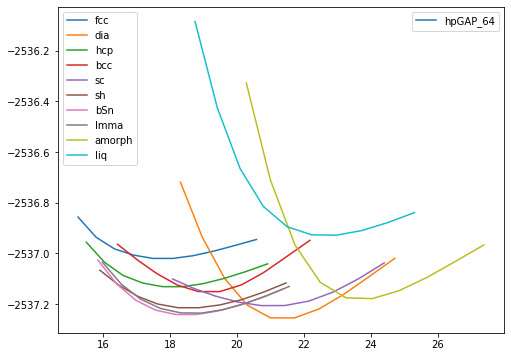

In [49]:
styl_list=['-','--','-.',':', (0, (3,6,3,6,3,10))]
df = Ge_cryst.df
fig, axs = plt.subplots(figsize=(8,6))
for i in range(len(df['Structure'])):
    if i in []:
        continue
    line, = axs.plot(df['Volumes'][i], df[df.columns[2]][i], label=df.index[i])
    if i == 0:
        hands = [line]
    for j, val in enumerate([]):
        tmp, = axs.plot(df['Volumes'][i], df[val][i], linestyle=styl_list[j+1], color=line.get_color())
        if i == 0:
            hands.append(tmp)
l1 = axs.legend(loc='upper left')
axs.legend()
l2 = axs.legend(hands, df.columns[2:4], loc='upper right')
axs.add_artist(l1)
fig.savefig(GE+'Analysis/Ge_EV_hp_2.png')

In [42]:
Ge_cryst.df.head()

,Structure,Volumes,hpGAP_64,H(P) hpGAP_64,P
fcc,"(Atom('Ge', [-0.04282724384583689, -0.04282724...","[15.242077275946876, 15.783166475771484, 16.33...","[-2536.856864284072, -2536.9365671121536, -253...","[-2537.021737015639, -2536.909410795399, -2536...","[0.0, 1.0101010101010102, 2.0202020202020203, ..."
dia,"(Atom('Ge', [-0.11313603890312772, -0.04277359...","[15.829096172572731, 16.391024368244608, 16.96...","[-2536.964486959476, -2537.0890531228392, -253...","[-2537.243146928549, -2537.1265538112575, -253...","[0.0, 1.0101010101010102, 2.0202020202020203, ..."
hcp,"(Atom('Ge', [3.2721998941999014e-13, -0.034320...","[15.489401545676712, 16.039270683352477, 16.60...","[-2536.956163422037, -2537.0361193916165, -253...","[-2537.1330733109776, -2537.01909251006, -2536...","[0.0, 1.0101010101010102, 2.0202020202020203, ..."
bcc,"(Atom('Ge', [-0.033541981308472954, -0.0335419...","[16.424378443870523, 17.007438982727322, 17.60...","[-2536.9643443534687, -2537.0251551544693, -25...","[-2537.154560981331, -2537.0334641734594, -253...","[0.0, 1.0101010101010102, 2.0202020202020203, ..."
sc,"(Atom('Ge', [3.076226019642305e-18, -1.3626202...","[18.070145893181504, 18.711630685906265, 19.36...","[-2537.101332828143, -2537.1389842312974, -253...","[-2537.2082924384604, -2537.075566359967, -253...","[0.0, 1.0101010101010102, 2.0202020202020203, ..."


In [17]:
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

def curve_crossing(y1, y2, x1, x2, delta=1):
    f1 = interp1d(x1, y1)
    f2 = interp1d(x2, y2)
    #print(f1(1), f1(90), f2(1), f2(90))
    xnew = np.linspace(np.amin(x1), np.amax(x1), 1000)
    base = f1(xnew) - f2(xnew)
    #print(root_scalar(lambda x: f1(x) - f2(x), bracket=[np.amin(x1)+10, np.amax(x1)-10]))
    a=len(xnew); xcross=[1]
    while a >= 1:
        tmp = np.argwhere(abs(base) < delta)
        delta *= 0.95
        a = len(tmp)
        if a == 0:
            return np.average(xnew[xcross])
        else:
            xcross = tmp

In [19]:
curve_crossing(df[df.columns[3]][6], df[df.columns[3]][7], df['P'][0], df['P'][0])

0.0

In [83]:
df = Ge_cryst.df
print(df.columns[11])
df.head()
# 7 9 11

H(P) hpGAP_full


,Structure,Volumes,0P GAP,hp_sup30_orig,hpGAP_64,hpGAP_amoliq,hpGAP_full,H(P) 0P GAP,H(P) hp_sup30_orig,H(P) hpGAP_64,H(P) hpGAP_amoliq,H(P) hpGAP_full,P
fcc,"(Atom('Ge', [-8.901032830871321e-13, 4.9651984...","[13.221686899980359, 13.691052843711113, 14.17...","[-2536.659301703214, -2536.856798023801, -2537...","[-2536.965512277582, -2537.041356504116, -2537...","[-2536.8396771756775, -2536.925015920401, -253...","[-2536.8536106804, -2536.9292320719987, -2536....","[-2536.9508036920097, -2537.021744022358, -253...","[-2537.282988037878, -2537.185650360642, -2537...","[-2537.150045122636, -2537.034818102476, -2536...","[-2537.0217594130113, -2536.909793505184, -253...","[-2537.0147257781396, -2536.9017013483576, -25...","[-2537.1200595664045, -2537.0047652440103, -25...","[0.0, 1.0135135135135136, 2.027027027027027, 3..."
dia,"(Atom('Ge', [0.19386521186352992, -1.348719070...","[18.59802772744367, 19.2582521679298, 19.93391...","[-2536.9049747984977, -2537.071506690797, -253...","[-2536.848914189853, -2537.035598063189, -2537...","[-2536.6952502869835, -2536.9175128863085, -25...","[-2536.83330361749, -2537.0267707953367, -2537...","[-2536.773386923086, -2536.98942643925, -2537....","[-2537.3250175296143, -2537.188028684942, -253...","[-2537.3395208972324, -2537.2038359820326, -25...","[-2537.2603153314517, -2537.1253805875467, -25...","[-2537.298926630418, -2537.1611349625505, -253...","[-2537.1951971121057, -2537.0887779325326, -25...","[0.0, 1.0135135135135136, 2.027027027027027, 3..."
hcp,"(Atom('Ge', [9.930594779670479e-13, 2.48355210...","[13.619052584514394, 14.102524891596401, 14.59...","[-2536.912450050236, -2537.02702532372, -2537....","[-2536.991698753878, -2537.050270668373, -2537...","[-2536.95884724292, -2537.037844828263, -2537....","[-2536.91412834268, -2536.9966280318226, -2537...","[-2536.9532765893614, -2537.031814855538, -253...","[-2537.2623771354497, -2537.1614361684947, -25...","[-2537.134947089926, -2537.0204477501966, -253...","[-2537.133226825992, -2537.019309599764, -2536...","[-2537.1005071086593, -2536.9875659289337, -25...","[-2537.1333932994644, -2537.0198913353343, -25...","[0.0, 1.0135135135135136, 2.027027027027027, 3..."
bcc,"(Atom('Ge', [-5.65861237787542e-13, -3.5987411...","[12.878182971233391, 13.335354627887828, 13.80...","[-2536.6846418348946, -2536.8558111250813, -25...","[-2537.0735387889977, -2537.1080573994827, -25...","[-2536.9638952147343, -2537.0250346935672, -25...","[-2536.9711962247593, -2537.0292701454555, -25...","[-2537.0715472443444, -2537.1070600827575, -25...","[-2537.2204902757435, -2537.1958657152336, -25...","[-2537.1699476415442, -2537.048025237061, -253...","[-2537.154572281399, -2537.033477494918, -2536...","[-2537.1518254798802, -2537.027263579804, -253...","[-2537.166006782195, -2537.0442350769695, -253...","[0.0, 1.0135135135135136, 2.027027027027027, 3..."
sc,"(Atom('Ge', [1.4187879228280545e-17, 4.6484204...","[18.083840986385685, 18.725811950836853, 19.38...","[-2537.181315738988, -2537.209193535943, -2537...","[-2537.153070253221, -2537.172844390206, -2537...","[-2537.1016682810837, -2537.139257740379, -253...","[-2537.1058780543717, -2537.1402777184035, -25...","[-2537.119088352765, -2537.146767632992, -2537...","[-2537.269360930674, -2537.136560228223, -2537...","[-2537.223777328802, -2537.0878613088994, -253...","[-2537.2083124619116, -2537.075421240482, -253...","[-2537.202346817282, -2537.067426899382, -2536...","[-2537.2081545089613, -2537.070863090925, -253...","[0.0, 1.0135135135135136, 2.027027027027027, 3..."


[(-0.26, 0.2), (0.0, 60.0)]

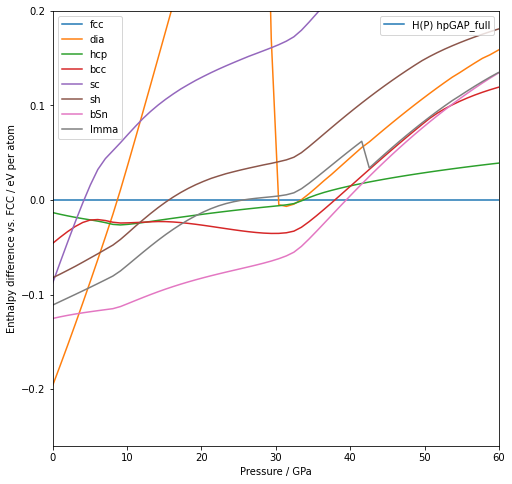

In [95]:
# enthalpy-volume curves
styl_list=['-','--','-.',':', (0, (3,6,3,6,3,10))]
df = Ge_cryst.df
col = df.columns
fig, axs = plt.subplots(figsize=(8,8))
for i in range(len(df['Structure'][:8])):
    if i in []:
        continue
    line, = axs.plot(df['P'][i], df[col[9]][i] - df[col[9]][0], label=df.index[i])
    # line, = axs.plot(df['P'][i], df[col[3]][i], label=df.index[i])
    if i == 0:
        hands = [line]
    for j, val in enumerate([]):
        tmp, = axs.plot(df['P'][i], df[val][i], linestyle=styl_list[j], color=line.get_color())
        if i == 0:
            hands.append(tmp)

# axs.axvline(curve_crossing(df[df.columns[5]][1], df[df.columns[5]][6], df['P'][0], df['P'][0]),
#             color='k', linestyle='--', linewidth=0.5)
# axs.axvline(curve_crossing(df[df.columns[5]][6], df[df.columns[5]][7], df['P'][0], df['P'][0]),
#             color='k', linestyle='--', linewidth=0.5)

l1 = axs.legend(loc='upper left')
axs.legend()
l2 = axs.legend(hands, [df.columns[11]], loc='upper right')
axs.add_artist(l1)
#l2.remove()
axs.set(xlabel='Pressure / GPa', ylabel='Enthalpy difference vs. FCC / eV per atom')
#axs.set(xlim=(0,10), ylim=(-2537.5,-2536))
axs.set(xlim=(0,60), ylim=(-0.26, 0.2))
#fig.savefig(GE+'Analysis/Ge_HP_hpGAP_64.png')


NameError: name 'Si_V' is not defined

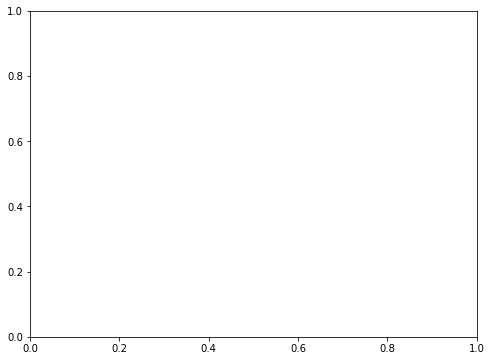

In [23]:
labels = ['fcc', 'dia', 'hcp', 'bcc', 'sc', 'sh']\
         + ['amorph', 'liquid', 'bad quench']
styl_list=['-','--','-.',':']
fig, axs = plt.subplots(figsize=(8,6))
for i in range(len(Si_V)):
    if i in []:
        continue
    line, = axs.plot(Si_V[i], Si_Es[0][i], label=labels[i])
    if i == 0:
        hands = [line]
    for j in range(len(Si_Es[1:])):
        tmp, = axs.plot(Si_V[i], Si_Es[j+1][i], linestyle=styl_list[j+1], color=line.get_color())
        if i == 0:
            hands.append(tmp)
l1 = axs.legend(loc='lower left')
l2 = axs.legend(hands, Si_pot_labels, loc='lower right')
axs.add_artist(l1)

In [38]:
Si_1000_MD = MD_run('/Users/Moji/Documents/Summer20/Ge/MD_runs/Si_liquid_gen/as5_ds002_vT/run_1000')
tmp = Si_1000_MD.structure_factors(selection=range(34,95), rings_dir=Si_1000_MD.run_dir+'/rings')
Si_1000_MD.bin_fit(nbins=200, q_selection=[1,12], s_selection=range(30,61))

In [180]:
Ge_hpliq_64_MD = MD_run(GE+'MD_runs/Ge_hp/hpliq_64/run_64001')

In [186]:
Ge_hpliq_64_MD.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 1000 to 240000
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Configs       240 non-null    object 
 1   CPU           240 non-null    float64
 2   Temp          240 non-null    float64
 3   f_TempAve     240 non-null    float64
 4   Press         240 non-null    float64
 5   f_PressAve    240 non-null    float64
 6   f_PEAve_Atom  240 non-null    float64
 7   Volume        240 non-null    float64
 8   f_vAve        240 non-null    float64
 9   c_MSD[4]      240 non-null    float64
dtypes: float64(9), object(1)
memory usage: 20.6+ KB


In [16]:
Si_hp_MDs = [MD_run(GE+'/MD_runs/Si_hp_liquid/'+i) for i in
sorted([i for i in os.listdir(GE+'/MD_runs/Si_hp_liquid') if 'run' in i],
       key=lambda x: int(x.split('_')[-1]))]



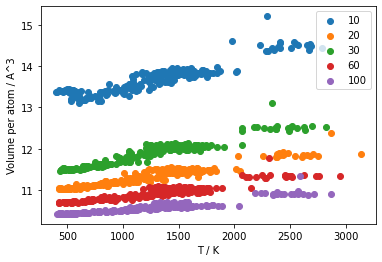

In [114]:
#df = Ge_hpliq_64_MD.df
fig, axs = plt.subplots()
for i in [0,2,3,5,9]:
    df = Si_hp_MDs[i].df
    axs.scatter(df['Temp'], df['f_vAve']/64, label=str((i+1)*10))
    axs.set(xlabel='T / K', ylabel='Volume per atom / A^3')
    axs.legend()

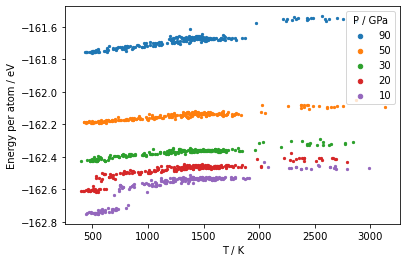

In [136]:
fig, axs = plt.subplots()
for i in reversed(list([2,3,5,9])):
    df = Si_hp_MDs[i].df
    axs.scatter(df['Temp'], df['f_PEAve_Atom'], label=str(i*10), s=5)
axs.set(xlabel='T / K', ylabel='Energy per atom / eV')
df = Si_hp_MDs[0].df
axs.scatter(df['Temp'], df['f_PEAve_Atom'], label=str(10), s=5)
axs.legend(title='P / GPa', markerscale=2)
fig.savefig(GE+'Analysis/Si_hp_MD_PE.png', bbox_inches='tight')

In [133]:
sorted([i for i in os.listdir(GE+'/MD_runs/Si_hp_liquid') if 'run' in i],
       key=lambda x: int(x.split('_')[-1]))

['run_1',
 'run_2',
 'run_3',
 'run_4',
 'run_5',
 'run_6',
 'run_7',
 'run_8',
 'run_9',
 'run_10']

In [30]:
Ge_hpliq_64_1000MD = MD_run(GE+'MD_runs/Ge_hp/hpliq_64/run_1000_001')

In [140]:
tmp = Ge_hpliq_64_1000MD.structure_factors(selection=([i for i in range(40,120)]),
                              rings_dir=GE+'MD_runs/Ge_hp/hpliq_64/rings',
                              read_only=False)

R.I.N.G.S ran successfully


In [145]:
#resc_amo_MD.bin_fit(s_selection=range(0,-1,1), q_selection=[1,12], nbins=200)
Ge_hpliq_64_1000MD.bin_fit(q_selection=[1,12], nbins=200)

In [139]:
Ge_hpliq_64_1000MD.df

,Configs,CPU,Temp,f_TempAve,Press,f_PressAve,f_PEAve_Atom,Volume,f_vAve,c_MSD[4]
1000,"(Atom('Ge', [0.60746588357, 2.57206154751, 2.9...",423.37642,2566.1567,2539.4155,1655.386500,3924.257800,-2536.8456,24669.813,24169.656,15.688344
2000,"(Atom('Ge', [2.423157165, 0.21264821175, 0.494...",823.55573,2584.6282,2504.6097,3642.255200,23.665180,-2536.8404,24200.200,24407.551,33.033947
3000,"(Atom('Ge', [0.92174538505, 2.1961277580200003...",1221.36230,2601.4071,2524.5532,839.769610,-285.322650,-2536.8338,24499.354,24577.338,52.771270
4000,"(Atom('Ge', [0.17666119153999998, 3.0764378689...",1627.40970,2471.5279,2483.8216,-133.133870,-128.221180,-2536.8383,24718.238,24537.299,72.011865
5000,"(Atom('Ge', [0.42970576857000004, 1.9417385820...",2032.98820,2414.2579,2503.5703,-1371.838100,-515.287850,-2536.8319,24434.288,24681.674,90.089247
...,...,...,...,...,...,...,...,...,...,...
136000,"(Atom('Ge', [6.6264459248, 5.706494515799999, ...",6591.06060,1262.0506,1312.6177,57.310676,-494.732120,-2536.9740,21852.806,21884.947,1464.068400
137000,"(Atom('Ge', [1.9656565289999999, 6.23314908, 6...",6995.87800,1310.6610,1309.6572,-705.395510,43.295958,-2536.9733,21928.391,21910.096,1470.312500
138000,"(Atom('Ge', [5.121642564, 3.7785484248000003, ...",7406.50990,1252.7801,1284.4238,-378.116850,234.246570,-2536.9749,21782.240,21895.124,1473.775100
139000,"(Atom('Ge', [6.776693235000001, 3.820836357000...",7819.48090,1248.0876,1274.7399,1382.942200,185.177200,-2536.9771,21865.018,21818.704,1483.195000


In [147]:
Ge_exp_Sq = np.genfromtxt('/Users/Moji/Documents/paper_data/Ge_Sq_exp.txt', delimiter=', ').T



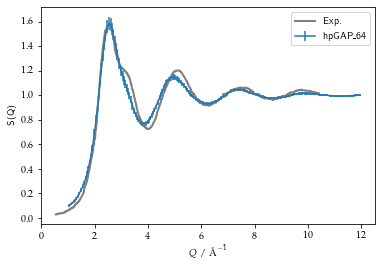

In [162]:
fig, axs = plt.subplots()
axs.errorbar(*Ge_hpliq_64_1000MD.Sq_x_av, yerr=Ge_hpliq_64_1000MD.Sq_x_std[1],
            label='hpGAP\_64')
axs.plot(*Ge_exp_Sq, color='Gray', linewidth=2, label='Exp.')
axs.legend()
axs.set(xlabel=r'$Q \;/\; \si{\angstrom}^{-1}$', ylabel='S(Q)')
fig.savefig(GE+'Analysis/Sq_hpGAP_64.png', bbox_inches='tight', dpi=100)

In [169]:
a = Ge_hpliq_64_1000MD.df['c_MSD[4]']
b = [a[1000*(i+1)] - a[1000*i] for i in range(30,140)]
print(np.average(b), np.std(b))

9.487844727272726 7.122273195112099


In [170]:
c = Ge_hpliq_64_1000MD.df['c_MSD[4]']
d = [a[1000*(i+1)] - a[1000*i] for i in range(1,20)]
print(np.average(d), np.std(d))


19.22641294736842 2.436402557759588


In [17]:
descriptor = Descriptor(
                        'soap average=T l_max=6 n_max=12 atom_sigma=0.5 \
                              cutoff=5.0 cutoff_transition_width=1.0 \
                              central_weight=1.0')
descs = [np.array([descriptor.calc_descriptor(i) for i in j.df['Configs']])
         for j in Si_hp_MDs]
zeta = 4
a = flatten(descs)
k_mat = np.array([[2 - 2*np.dot(i[0]**zeta, j[0]**zeta) for j in a] for i in a])
pca = decomposition.PCA(n_components=2)
pca.fit(k_mat)
red = pca.fit_transform(k_mat)

In [ ]:
p = pd.concat([i.df['f_PressAve'] for i in Si_hp_MDs])
#c = pd.concat([i.df['f_TempAve'] for i in Si_hp_MDs])


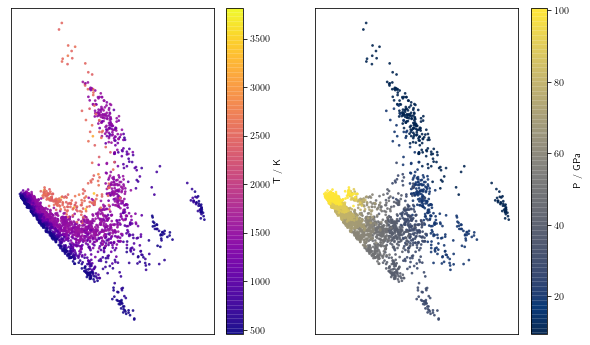

In [49]:
fig, axs = plt.subplots(1,2, figsize=(10,6))
im1 = axs[0].scatter(red.T[0], red.T[1], c=c, cmap='plasma', alpha=0.8, s=3)
cbar = fig.colorbar(im1, ax=axs[0])
cbar.set_label('T / K')
im2 = axs[1].scatter(red.T[0], red.T[1], c=p*1e-4, cmap='cividis', alpha=0.8, s=3)
cbar2 = fig.colorbar(im2, ax=axs[1])
cbar2.set_label('P / GPa')
axs[0].get_xaxis().set_visible(False)
axs[0].get_yaxis().set_visible(False)
axs[1].get_xaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)